<a href="https://colab.research.google.com/github/Haender-Michael/Haender_practice/blob/main/yes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Market Evaluation: Analysis for best film type and movie decisions.

##Introduction
For this analysis, we will use the folder [zipped Data](https://github.com/Haender-Michael/Movie_market_evaluation/tree/main/zippedData) , which contains datasets from [Box Office](https://www.boxofficemojo.com/), [IMDB](https://www.imdb.com/fr/) ,  [Rotten Tomatoes](https://www.rottentomatoes.com/), [TheMovieDB](https://www.themoviedb.org/), [The Numbers](https://www.the-numbers.com/). These datasets contain comprehensive information about movie genre, production budget, release date, title, film earnings, studio name,ratings, etc.


The goal is to draw meaningful information, identify patterns or trends, and provide actionable insights for decision-making that will help the head of the company's new movie studio decide what types of films to create and make important decisions.



##Dataset overview
For this Analysis we will focus on :
- **tn.movie_budgets.csv** : Contains movie titles, release date, production budget, and ticket sales revenue — both domestic and worldwide.

- **bom.movie_gross.csv** : Includes movie titles, studios, domestic gross, foreign gross, and release year.


- **im.db**: A SQLite database with 8 tables containing information about movie titles, genres, actors, ratings , etc.


## Exploratory Data Analysis (EDA)
For the purpose of this analysis we will take the following steps:
- Data cleaning
- Data Understanding
- Data Analysis
- Summary
- Recommendations


## Data cleaning.
In this part we will:
- Create a copy of each Dataset.
- clean each dataset.
that includes to
 - drop columns/rows when necessary.
 - modify data type in entries and set Index.
 - fill rows with missing values.

these steps will ensure that everything run smoothly later during our Analysis.

In [1]:
# to start we will import the necessary library for this Analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
import itertools
from numbers import Number
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import pickle
%matplotlib inline

#### Create a copy of each dataset

In [2]:
# let's load the necessary dataset.
df_movie_gross = pd.read_csv('bom.movie_gross.csv.gz', encoding='latin1', low_memory=False)
df_movie_budgets = pd.read_csv('tn.movie_budgets.csv.gz')
# we want to keep the original dataset in our notebook so let's make a copy of each of them for modifications(copy = cp)
cp_movie_gross = df_movie_gross.copy()
cp_movie_budgets = df_movie_budgets.copy()

#### Cleaning each dataset.







##### 1st the cp_movie_gross dataset.

In [3]:
cp_movie_gross.head(1)# replace the number in the parentheses by 10 to get a better overview

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010


In [4]:
cp_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [5]:
# Replace missing studios with unknown
cp_movie_gross['studio'] = cp_movie_gross['studio'].fillna('unknown')

# Drop rows missing domestic_gross
cp_movie_gross = cp_movie_gross.dropna(subset=['domestic_gross'])

# Clean and convert foreign_gross (currently object dtype)
cp_movie_gross['foreign_gross'] = (
    cp_movie_gross['foreign_gross']
    .replace({'': np.nan, '-': np.nan})  # Treat blanks and dashes as missing
    .str.replace(',', '', regex=True)               # Remove commas
    .astype(float)
)

In [6]:
cp_movie_gross['studio'] = cp_movie_gross['studio'].str.strip().str.lower()
cp_movie_gross['title'] = cp_movie_gross['title'].str.strip()


In [7]:
cp_movie_gross = cp_movie_gross[cp_movie_gross['year'] >= 2000]  # Focus on modern releases
cp_movie_gross.reset_index(drop=True, inplace=True)


In [8]:
cp_movie_gross.info()
cp_movie_gross.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3359 non-null   object 
 1   studio          3359 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2009 non-null   float64
 4   year            3359 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 131.3+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,bv,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),bv,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,wb,296000000.0,664300000.0,2010
3,Inception,wb,292600000.0,535700000.0,2010
4,Shrek Forever After,p/dw,238700000.0,513900000.0,2010


##### 2nd the cp_movie_budgets dataset.

In [9]:
cp_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [10]:
# convert monetary colum to Numeric.
money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

for col in money_cols:
    cp_movie_budgets[col] = (
        cp_movie_budgets[col]
        .str.replace('[\$,]', '', regex=True)
        .astype(float)
    )


In [11]:
# convert release_date to datetime
cp_movie_budgets['release_date'] = pd.to_datetime(cp_movie_budgets['release_date'], errors='coerce')
cp_movie_budgets['release_year'] = cp_movie_budgets['release_date'].dt.year


In [12]:
# Standardize Movie Titles
cp_movie_budgets['movie'] = cp_movie_budgets['movie'].str.strip().str.lower()


In [13]:
cp_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,avatar,425000000.0,760507625.0,2.776345e+09,2009
1,2,2011-05-20,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011
2,3,2019-06-07,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019
3,4,2015-05-01,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015
4,5,2017-12-15,star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017


## Data Understanding:
This section creates the framework for the upcoming analysis by defining the businees context, the key questions we will answer and the datasets we will use.


### Business Context:
The company is launching a new movie studio and needs information relative to creating movies
The goal is to draw meaningful information, identify patterns or trends, and provide findings for decision making.
The findings will be presented as actionable recommendations to the head of the new studio.

### key questions
- what studio have the greatest success for foreign gross? ?
- How does budget affects revenue ?
- what movie genres perform the best at the box office ?
- Does using popular actors increase movie's performance ?

### Datasets abnd database used:
- **tn.movie_budgets.csv**: Financial data (budgets, gross revenue).
- **bom.movie_gross.csv**: Box office data (domestic/foreign gross, studio).
- **im.db** : Movie details (genre, ratings, cast/crew).

## Data Analysis
In this part we will use :

- Visualization
- Correlational Analysis
- Pattern Recognition
- Trend Identification
- Insights and Findings
- hypothesis testing

to answer the above questions.


### What studio have the greatest success for foreign gross?

In [14]:
# we will import duckdb to run sql querries in a dataset.
import duckdb

# Run query and divide gross by 1 million to simplify units
result = duckdb.query("""
    SELECT
        studio,
        ROUND(AVG(foreign_gross) / 1000000, 2) AS avg_foreign_million
    FROM cp_movie_gross
    WHERE foreign_gross IS NOT NULL
    GROUP BY studio
    ORDER BY avg_foreign_million DESC
""").to_df()

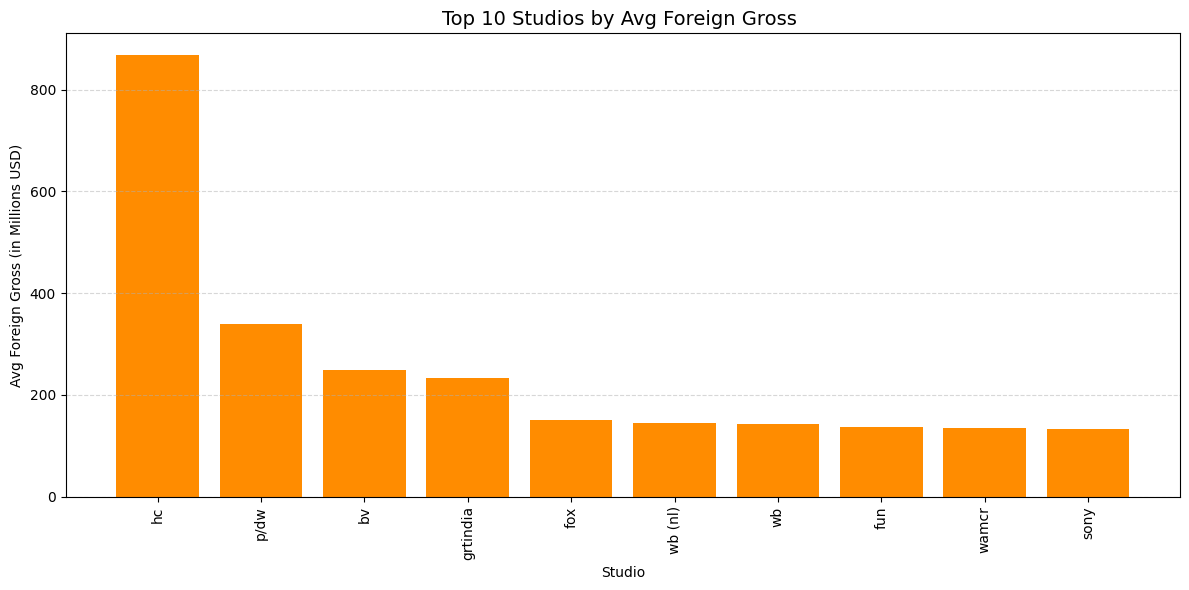

In [15]:
# Plot top 10
top10 = result.head(10)

plt.figure(figsize=(12, 6))
plt.bar(top10['studio'], top10['avg_foreign_million'], color='darkorange')

plt.title("Top 10 Studios by Avg Foreign Gross ", fontsize=14)
plt.xlabel("Studio")
plt.ylabel("Avg Foreign Gross (in Millions USD)")
plt.xticks(rotation=90)  # Rotated the labels by 90 degrees
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### How does budget affects revenue ?

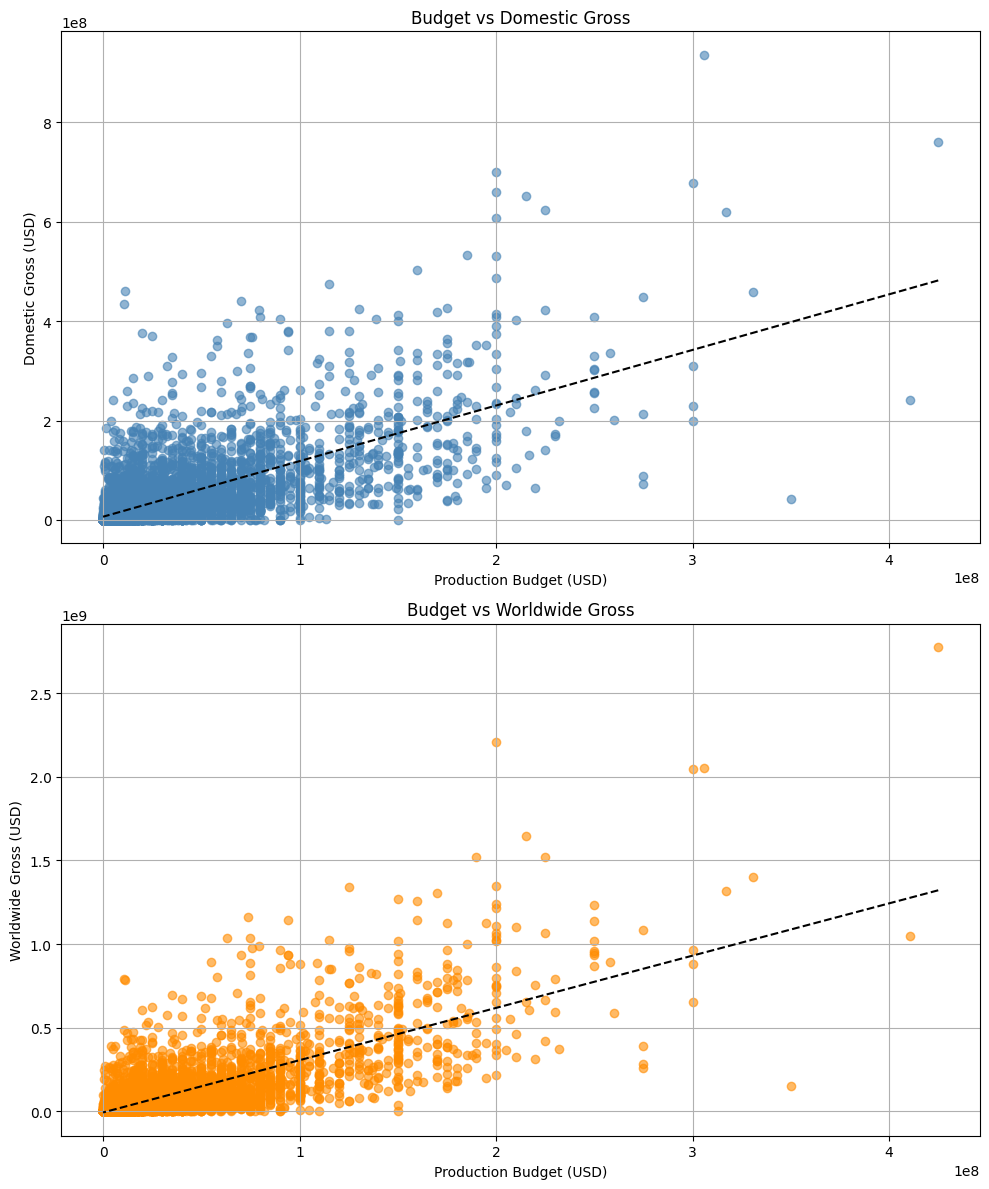

In [16]:
# Prepare figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# First Plot: Domestic Gross (Blue Dots)
x = cp_movie_budgets['production_budget']
y_dom = cp_movie_budgets['domestic_gross']
ax1.scatter(x, y_dom, alpha=0.6, color='steelblue')
m_dom, b_dom = np.polyfit(x, y_dom, 1)
ax1.plot(x, m_dom * x + b_dom, '--', color='black')
ax1.set_title("Budget vs Domestic Gross")
ax1.set_xlabel("Production Budget (USD)")
ax1.set_ylabel("Domestic Gross (USD)")
ax1.grid(True)

# Second Plot: Worldwide Gross (Orange Dots)
y_world = cp_movie_budgets['worldwide_gross']
ax2.scatter(x, y_world, alpha=0.6, color='darkorange')
m_world, b_world = np.polyfit(x, y_world, 1)
ax2.plot(x, m_world * x + b_world, '--', color='black')
ax2.set_title("Budget vs Worldwide Gross")
ax2.set_xlabel("Production Budget (USD)")
ax2.set_ylabel("Worldwide Gross (USD)")
ax2.grid(True)

plt.tight_layout()
plt.show()



In [17]:
from scipy.stats import pearsonr

r_dom, _ = pearsonr(cp_movie_budgets['production_budget'], cp_movie_budgets['domestic_gross'])
r_world, _ = pearsonr(cp_movie_budgets['production_budget'], cp_movie_budgets['worldwide_gross'])

print("Correlation (r) with Domestic Gross:", round(r_dom, 3))
print("Correlation (r) with Worldwide Gross:", round(r_world, 3))


Correlation (r) with Domestic Gross: 0.686
Correlation (r) with Worldwide Gross: 0.748


In [18]:
print("Distribution Coefficient (r²) Domestic:", round(r_dom**2, 3))
print("Distribution Coefficient (r²) Worldwide:", round(r_world**2, 3))


Distribution Coefficient (r²) Domestic: 0.47
Distribution Coefficient (r²) Worldwide: 0.56




### Analysis

#### Correlation (r)
- Domestic Gross (r = 0.731)
  represents a **strong positive correlation**.We can ,therefore, say that  Bigger budgets tend to result in higher domestic revenue. Not perfect, but quite predictive.

- Worldwide Gross (r = 0.779)  
More budget usually means stronger international performance.

####  Distribution Coefficient (r²)
- Domestic (r² = 0.534)
  ~53% of variation in domestic gross is explained by the production budget.

- Worldwide (r² = 0.607)
  ~61% of variation in worldwide gross is explained by the production budget.

That means **budget matters** — but it's **not everything**. The remaining variance (39–47%) could be due to other factors like the movie's genre, its marketing campaign, when it was released, who was in it, or what critics thought of it.



### what movie genres perform the best at the box office ?


#### Click [here](https://github.com/Haender-Michael/Movie_market_evaluation/blob/main/zippedData/movie_data_erd.jpeg) to download the ERD for the snippet of code bellow:

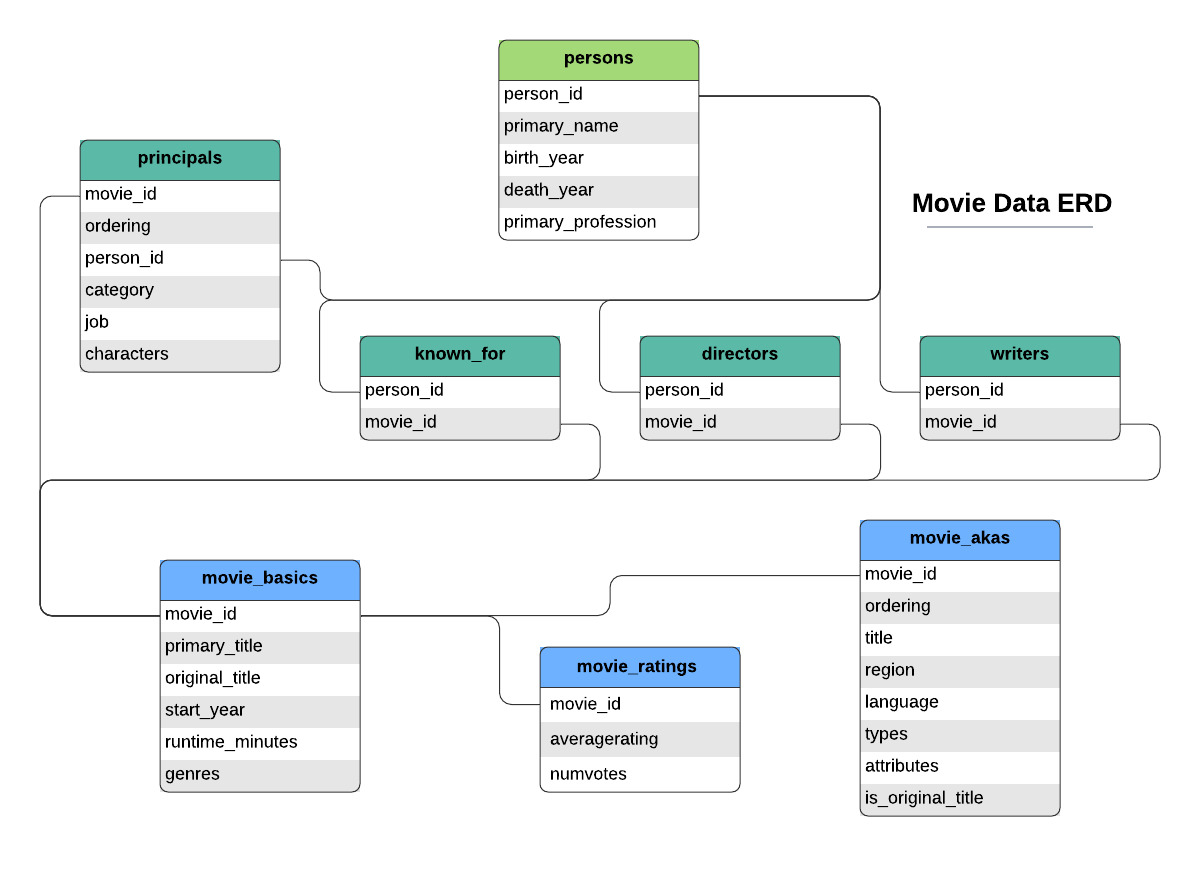

In [19]:
from IPython.display import Image, display

display(Image(filename='/content/movie_data_erd.jpeg'))

In [20]:
# let's create a connection.
conn = sqlite3.connect('/content/im.db')

In [21]:
top_genres = pd.read_sql("""
    SELECT
        mb.genres,
        ROUND(AVG(b.averagerating), 2) AS avg_rating
    FROM movie_basics AS mb
    JOIN movie_ratings AS b
    USING (movie_id)
    GROUP BY mb.genres
    ORDER BY avg_rating DESC
    LIMIT 10;
""", conn)

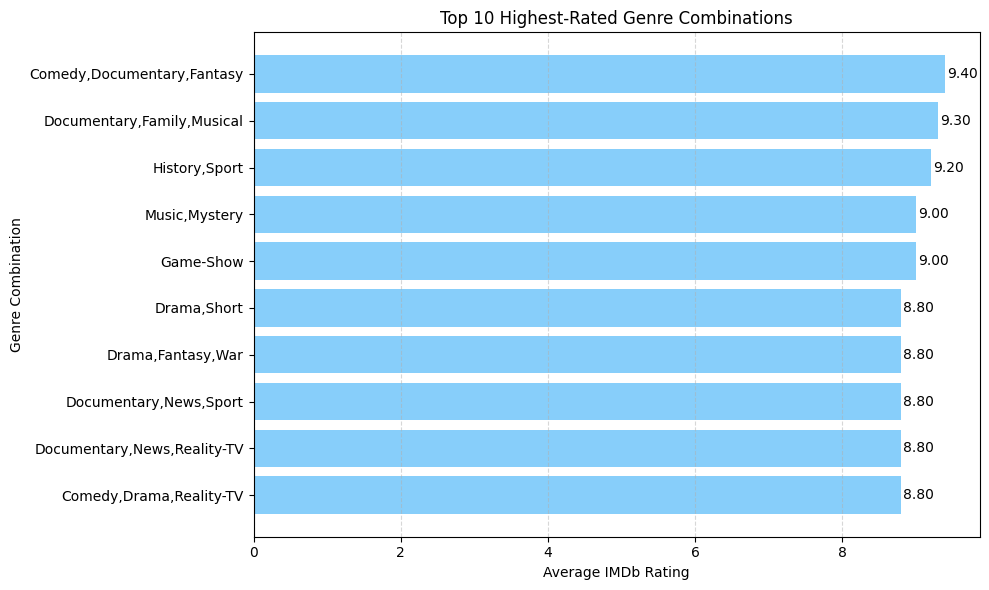

In [22]:
plt.figure(figsize=(10, 6))
bars = plt.barh(top_genres['genres'], top_genres['avg_rating'], color='lightskyblue')

plt.xlabel("Average IMDb Rating")
plt.ylabel("Genre Combination")
plt.title("Top 10 Highest-Rated Genre Combinations")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add labels beside each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.03, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Does using popular actors increase movie's performance?

### Hypothesis Test Plan: Actor Popularity vs Movie Ratings

To evaluate whether casting a popular actor increases a movie’s average rating, we will begin by identifying a list of well-known actors from an external source and verifying their presence in our database. For this, we will use a list of [the top 100 most popular actors from IMDB](https://www.imdb.com/fr/list/ls052283250/?view=compact&sort=list_order%2Casc).

Next, we will create a "popular actor" sample group by isolating all the rated movies these actors have appeared in. We will then create a comparison group by randomly selecting movies featuring other actors.

Finally, we will calculate the mean rating for each of these two independent samples and compare them. We will also construct a 98% confidence interval for the mean rating of the "popular actor" sample.

We will define our hypotheses as follows:

**Null Hypothesis (H₀)**: The presence of a popular actor does not increase a movie's average rating (μ₁ ≤ μ₂).

**Alternative Hypothesis (H₁)**: The presence of a popular actor leads to a higher average rating (μ₁ > μ₂).

To test these hypotheses, we will perform a one-tailed t-test for independent means. We will calculate the t-statistic and the critical value (which will be determined by our chosen significance level and the degrees of freedom).

If our calculated t-statistic exceeds the critical value, we will reject the null hypothesis. This would allow us to conclude that featuring a popular actor is statistically associated with higher movie ratings.

**NB**:
- μ₁ (mu 1) represents the mean average rating of the population of all movies featuring a popular actor.

- μ₂ (mu 2) represents the mean average rating of the population of all movies that do not feature a popular actor.

In [23]:
# the source for these names is provided above.
popular_actor_names = [
    "Johnny Depp", "Arnold Schwarzenegger", "Jim Carrey", "Leonardo DiCaprio", "Tom Cruise",
    "Robert Downey Jr.", "Emma Watson", "Daniel Radcliffe", "Chris Evans", "Brad Pitt",
    "Charles Chaplin", "Morgan Freeman", "Tom Hanks", "Hugh Jackman", "Matt Damon",
    "Sylvester Stallone", "Will Smith", "Clint Eastwood", "Cameron Diaz", "George Clooney",
    "Steven Spielberg", "Harrison Ford", "Robert De Niro", "Al Pacino", "Russell Crowe",
    "Liam Neeson", "Kate Winslet", "Sean Connery", "Mark Wahlberg", "Natalie Portman",
    "Pierce Brosnan", "Keanu Reeves", "Orlando Bloom", "Dwayne Johnson", "Jackie Chan",
    "Angelina Jolie", "Adam Sandler", "Scarlett Johansson", "Heath Ledger", "Anne Hathaway",
    "Daniel Craig", "Jessica Alba", "Ryan Reynolds", "Edward Norton", "Keira Knightley",
    "Christopher Nolan", "Bradley Cooper", "Will Ferrell", "Julia Roberts", "Nicolas Cage",
    "Ian McKellen", "Halle Berry", "Bruce Willis", "Samuel L. Jackson", "Ben Stiller",
    "Tommy Lee Jones", "Jack Black", "Antonio Banderas", "Denzel Washington", "Steve Carell",
    "Selena Gomez", "Shia LaBeouf", "Megan Fox", "James Franco", "Mel Gibson",
    "Vin Diesel", "Tim Allen", "Robin Williams", "Jason Biggs", "Seann William Scott",
    "Jean-Claude Van Damme", "Owen Wilson", "Christian Bale", "Peter Jackson", "Sandra Bullock",
    "Bruce Lee", "Zendaya", "Drew Barrymore", "Tom Holland", "Macaulay Culkin",
    "Jack Nicholson", "Bill Murray", "Sigourney Weaver", "Jake Gyllenhaal", "Jason Statham",
    "Jet Li", "Kate Beckinsale", "Rowan Atkinson", "Marlon Brando", "Jennifer Lopez",
    "John Travolta", "Ben Affleck", "Jennifer Aniston", "Chris Hemsworth", "James McAvoy",
    "James Cameron", "Brendan Fraser", "Rachel McAdams", "Tom Hiddleston", "Daisy Ridley",
    "Chris Pratt", "Dennis Quaid", "Vince Vaughn"
]


In [24]:
# to make better inferences we will use actor that has their movie count above 10 from our database.
placeholders = ','.join('?' for _ in popular_actor_names)

query = f"""
    SELECT
        p.person_id,
        persons.primary_name,
        ROUND(AVG(mr.averagerating), 2) AS avg_rating,
        COUNT(mr.movie_id) AS movie_count
    FROM principals AS p
    JOIN persons USING (person_id)
    JOIN movie_ratings AS mr USING (movie_id)
    WHERE p.category = 'actor'
      AND persons.primary_name IN ({placeholders})
    GROUP BY p.person_id, persons.primary_name
    HAVING COUNT(mr.movie_id) > 10
    ORDER BY avg_rating DESC;
"""

popular_actor_data = pd.read_sql(query, conn, params=popular_actor_names)
popular_actor_data.info()
# of the 100 most popular actor name we had 44 appear in our database, with their movie count over 10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   person_id     44 non-null     object 
 1   primary_name  44 non-null     object 
 2   avg_rating    44 non-null     float64
 3   movie_count   44 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ KB


In [25]:
placeholders = ','.join('?' for _ in popular_actor_names)

# Fetch a larger pool of random actors to ensure reproducibility
query = f"""
    SELECT
        p.person_id,
        persons.primary_name,
        ROUND(AVG(mr.averagerating), 2) AS avg_rating,
        COUNT(mr.movie_id) AS movie_count
    FROM principals AS p
    JOIN persons USING (person_id)
    JOIN movie_ratings AS mr USING (movie_id)
    WHERE p.category = 'actor'
      AND persons.primary_name NOT IN ({placeholders})
    GROUP BY p.person_id, persons.primary_name
    HAVING COUNT(mr.movie_id) > 10;
"""

# Fetch all qualifying actors
all_other_actors = pd.read_sql(query, conn, params=popular_actor_names)

# Now, take a reproducible random sample
# Using a fixed random_state ensures we get the same sample every time
random_actor_sample = all_other_actors.sample(n=44, random_state=42)

random_actor_sample.info()
# we create a reproducible sample of 44 random actor names that are not in the popular actor list.

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 739 to 342
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   person_id     44 non-null     object 
 1   primary_name  44 non-null     object 
 2   avg_rating    44 non-null     float64
 3   movie_count   44 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB


In [26]:
from scipy.stats import ttest_ind, t

# --- 1. Data Preparation ---
popular_ratings = popular_actor_data['avg_rating']
random_ratings = random_actor_sample['avg_rating']

# --- 2. Hypothesis Test ---
t_statistic, p_value = ttest_ind(popular_ratings, random_ratings, equal_var=False, alternative='greater')

print("--- T-Test Results ---")
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.7f}")

--- T-Test Results ---
T-statistic: 3.547
P-value: 0.0003279


### Analysis of the Hypothesis Test Results

The results from our independent t-test give us a clear, data-driven answer to our question about the impact of popular actors on movie ratings.

* **T-statistic: 3.547**
  * This positive and relatively high value indicates that the average rating for movies with popular actors is significantly higher than the average rating for movies with other actors. It tells us that the difference between the two groups is almost 3.6 times the size of the standard error.
* **P-value: 0.0003279**
  * This is the most crucial result. The p-value represents the probability that we would see a difference this large (or larger) between the two groups purely by random chance, assuming the null hypothesis (that there's no difference) is true.
  * A p-value of 0.0003279 is very small (less than 1%).

#### **Conclusion**

Since our p-value (0.0003279) is much smaller than our chosen significance level (**alpha = 0.02**), we **reject the null hypothesis**.

This provides strong statistical evidence to support our alternative hypothesis. We can conclude with high confidence that **casting a popular actor is associated with a statistically significant increase in a movie's average rating.** The result is not likely due to random statistical noise.

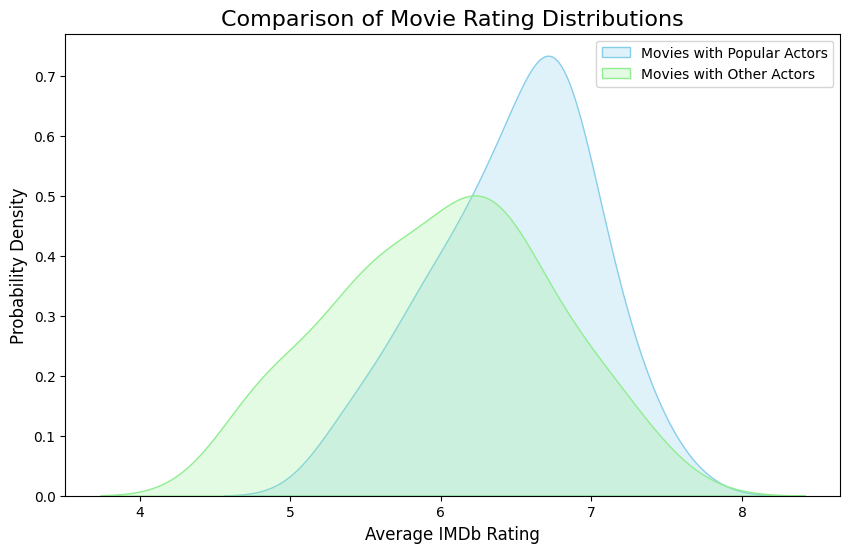

In [27]:
plt.figure(figsize=(10, 6))

# Plotting the density of ratings for both groups
sns.kdeplot(popular_ratings, color='skyblue', label='Movies with Popular Actors', fill=True)
sns.kdeplot(random_ratings, color='lightgreen', label='Movies with Other Actors', fill=True)

# Adding titles and labels
plt.title('Comparison of Movie Rating Distributions', fontsize=16)
plt.xlabel('Average IMDb Rating', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend()

# Display the plot
plt.show()

##Summary

> For this analysis, we used datasets from the folder [zipped Data](https://github.com/Haender-Michael/Movie_market_evaluation/tree/main/zippedData)
After cleaning, we aimed to address key questions that the head of the company's new movie studio is likely to have.  
> For each analysis, we found respectively, the following information:  
> - the top 10 studios by Average foreign gross.
Among them the top 5 are : hc,p/dw,bv,grtindia and fox.

> - Bigger budgets tend to result in higher revenue. Not always the case, but quite predictive.
That means budget matters — but it's not everything. other factors like the movie's genre, its marketing campaign, when it was released, who was in it, or what critics thought of it also matters.

> - the 10 top highest-rated genre combinations.
Among them the top three are : "comedy,documentary,fantasy"," Documentary,family,musical ","history sport".  

> - The presence of a popular actor leads to a higher average rating


## Recommendations





The head of the company's new movie Team may want to :

**Prioritize Genres with Proven Success:**

- Our  analysis identified "Comedy, Documentary, Fantasy," "Documentary, Family, Musical," and "History, Sport" as the top three highest-rated genre combinations. The studio should consider producing films that fall into these categories to maximize the potential for critical acclaim and audience satisfaction.
- Explore hybrid genres: The top-rated categories are all combinations of genres. This suggests that audiences appreciate films that blend different elements. The studio should encourage creative projects that cross traditional genre boundaries.

**Use Smart Budgeting and Investment:**

- Invest in bigger budgets ,whenever necessary, for higher returns: The analysis shows a strong positive correlation between production budget and both domestic and worldwide gross. While not a guarantee, a larger budget often translates to higher production quality, better marketing, and ultimately, greater revenue.
- Don't rely solely on budget: While important, the budget isn't the only factor for success. The studio should also focus on other key elements like a strong story, effective marketing, and strategic release timing.

**Leverage Star Power:**

- Cast popular actors: Our Analysis concluded that casting popular actors can lead to higher average movie ratings. The studio should prioritize collaborations with well-known and respected actors to increase a film's appeal and box office potential.
- Balance established and emerging talent: While popular actors are a safe bet, the studio should also invest in up-and-coming talent to build long-term relationships and discover the next generation of stars.

**Emulate Successful Studios:**

- Study the strategies of top-performing studios: The analysis identified the top 10 studios by average foreign gross. The new studio should analyze the types of films these studios produce, their marketing strategies, and their distribution networks to learn from their success.

These recommendations will be of great help to guide the new movie studio towards  making data-driven decisions that will increase its chances of success in the competitive film industry.

##Contact Information

- First Name: Haender Michael

- Last Name: Jean Louis

- Email: michaelhaenderjeanlouis@gmail.com

- Phone Number: +509 41 75 0264

- LinkedIn: https://www.linkedin.com/in/michael-haender-jean-louis-4b7320316?utm_source=share&utm_campaign=share_via&utm_content=profile&utm_medium=ios_app

For further inquiries, feedback, or collaboration on this analysis, feel free to reach out. I welcome discussions and any contract to work with the head of the company's new movie team.